# Lecture 8

In [30]:
import neat
import random
import networkx as nx
import os
import pandas as pd
from math import log, sqrt, exp
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Loading the synthetic data into pandas dataframes.

In [31]:
xls30_ = pd.ExcelFile("./data/synthetic_data//IOP_AOP_Sun30.xls")
xls60_ = pd.ExcelFile("./data/synthetic_data/IOP_AOP_Sun60.xls")
print(xls30_.sheet_names)

xls30 = {}
for sheet_name in xls30_.sheet_names:
    xls30[sheet_name] = xls30_.parse(sheet_name)
    xls30[sheet_name].drop(xls30[sheet_name].index[0:8], inplace=True)
    xls30[sheet_name].drop(xls30[sheet_name].columns[0], axis=1, inplace=True)
    xls30[sheet_name].reset_index(drop=True, inplace=True) 

xls60 = {}
for sheet_name in xls60_.sheet_names:
    xls60[sheet_name] = xls60_.parse(sheet_name)
    xls60[sheet_name].drop(xls60[sheet_name].index[0:8], inplace=True)
    xls60[sheet_name].drop(xls60[sheet_name].columns[0], axis=1, inplace=True)
    xls60[sheet_name].reset_index(drop=True, inplace=True) 

['Basics', 'a_ph', 'a_g', 'a_dm', 'a', 'bb_ch', 'bb_dm', 'bb', 'Rrs', 'R', 'r_rs', 'Kd(40)', 'Kd(20)', 'Kd(10)', 'Kd(5)', 'Kd(0)']


In [32]:
allbands = [f'{l}' for l in range(400,801,10)]
bands = ['411', '443', '489', '510', '560', '619', '665']
bands_n = [411, 443, 489, 510, 560, 619, 665]

In [33]:
input_params = ['Rrs'] # only at 7 wavelengths
output_params = ['a_ph', 'a_dm', 'a_g', 'bb_dm', 'bb_ch'] # only at 440nm wavelength

In [34]:
for param in input_params + output_params:
    xls30[param].columns = allbands
    xls60[param].columns = allbands

Preparing training data. Parameters at 443nm wavelength need to be calculated via interpolation.

In [35]:
x = np.linspace(400, 800, num=41) # available bands in synthetic data set
x_ = np.linspace(400, 800, num=401) # for interpolation at 1nm steps

inputs = []
for i in range(500): # 500 data points at 30 deg solar zenith, 500 at 60 deg solar zenith
    Rrs = xls30['Rrs'].loc[i]
    Rrs_ = np.interp(x_, x, Rrs)

    datapoint30 = ()
    for band in bands_n:
        datapoint30 += (log(Rrs_[band-400]),)
    inputs.append(datapoint30)

    Rrs = xls60['Rrs'].loc[i]
    Rrs_ = np.interp(x_, x, Rrs)

    datapoint60 = ()
    for band in bands_n:
        datapoint60 += (log(Rrs_[band-400]),)
    inputs.append(datapoint60)

outputs = []
for i in range(500):

    aph = xls30['a_ph'].loc[i]
    aph443 = np.interp(443, x, aph)

    adm = xls30['a_dm'].loc[i]
    adm443 = np.interp(443, x, adm)
    ag = xls30['a_g'].loc[i]
    ag443 = np.interp(443, x, ag)
    adg443 = adm443 + ag443

    bbch = xls30['bb_ch'].loc[i]
    bbch443 = np.interp(443, x, bbch)
    bbdm = xls30['bb_dm'].loc[i]
    bbdm443 = np.interp(443, x, bbdm)
    bbp443 = bbch443 + bbdm443

    datapoint30 = ()
    datapoint30 += (log(aph443),)
    datapoint30 += (log(adg443),)
    datapoint30 += (log(bbp443),)
    outputs.append(datapoint30)


    aph = xls60['a_ph'].loc[i]
    aph443 = np.interp(443, x, aph)

    adm = xls60['a_dm'].loc[i]
    adm443 = np.interp(443, x, adm)
    ag = xls60['a_g'].loc[i]
    ag443 = np.interp(443, x, ag)
    adg443 = adm443 + ag443

    bbch = xls60['bb_ch'].loc[i]
    bbch443 = np.interp(443, x, bbch)
    bbdm = xls60['bb_dm'].loc[i]
    bbdm443 = np.interp(443, x, bbdm)
    bbp443 = bbch443 + bbdm443

    datapoint60 = ()
    datapoint60 += (log(aph443),)
    datapoint60 += (log(adg443),)
    datapoint60 += (log(bbp443),)
    outputs.append(datapoint60)

The following are functions returning absorption and backscattering coefficients of pure water. Data is extracted from the synthetic data set.

In [36]:
bb_w = xls30['Basics']['Unnamed: 2'].tolist()
bb_w_ = np.interp(x_, x, bb_w)
a_w = xls30['Basics']['Unnamed: 1'].tolist()
a_w_ = np.interp(x_, x, a_w)

def bbw(l):
    return bb_w_[l-400]
def aw(l):
    return a_w_[l-400]

Now we prepare in-situ data for validation. The two data sets are kept separate.

In [37]:
# SEABASS DATA SET
Inputs_s = []
Outputs_s = []
sbands = [405,411,443,455,465,489,510,520,530,550,555,560,565,570,590,619,625,665,670,683]
bands_n = [411, 443, 489, 510, 560, 619, 665]

with open('nomad_seabass_v2.a_2008200.txt', 'r') as seabass:
    lines = seabass.readlines()
    fields = lines[88][8:].split(',')
    
    goodlines = 0
    lwc = 0
    esc = 0
    kdc = 0
    ac = 0
    bbc = 0

    maxrrs = []
    for i in range(91, 4550):
        line = lines[i]
        content = line.split(',')
        inpoint = ()
        outpoint = ()

        # LW
        lw_full = [float(content[fields.index('lw405')+j]) for j in range(20)]

        if sum(lw_full) == -999*len(lw_full):
            continue
        avail = [] # available bands indices (from sbands list)
        for j in range(len(lw_full)):
            if lw_full[j] != -999:
                avail.append(j) 
        if len(avail) == 0:
            continue

        lw = []
        for l in bands_n:
            lw.append(np.interp(l, [sbands[j] for j in avail], [lw_full[j] for j in avail]))

        # ES
        es_full = [float(content[fields.index('es405')+j]) for j in range(20)]

        if sum(es_full) == -999*len(es_full):
            continue

        avail = []
        for j in range(len(es_full)):
            if es_full[j] != -999:
                avail.append(j) 
        if len(avail) == 0:
            esc+=1
            continue

        es = []
        for l in bands_n:
            es.append(np.interp(l, [sbands[j] for j in avail], [es_full[j] for j in avail]))
            
        Rrs = []
        negative = 0
        one = 0
        for j in range(len(bands_n)):
            if lw[j]/es[j] < 0:
                negative = 1
                continue
            if lw[j]/es[j] == 1.0:
                one = 1
                continue
            Rrs.append(lw[j]/es[j])
        if negative == 1:
            continue
        if one == 1:
            continue
            
        a443 = float(content[fields.index('a443')])
        if a443 == -999:  
            a_full = [float(content[fields.index('a405')+j]) for j in range(20)]
            if sum(a_full) == -999*len(a_full):
                continue  
            avail = [] # available bands indices (from sbands list)
            for j in range(len(a_full)):
                if a_full[j] != -999:
                    avail.append(j) 
            
            a443 = np.interp(443, [sbands[j] for j in avail], [a_full[j] for j in avail])
        
        ap443 = float(content[fields.index('ap443')])
        if ap443 == -999:  
            ap_full = [float(content[fields.index('ap405')+j]) for j in range(20)]
            if sum(ap_full) == -999*len(ap_full):
                continue        
            avail = [] # available bands indices (from sbands list)
            for j in range(len(ap_full)):
                if ap_full[j] != -999:
                    avail.append(j) 
            
            ad443 = np.interp(443, [sbands[j] for j in avail], [ad_full[j] for j in avail])
   
          
        ad443 = float(content[fields.index('ad443')])
        if ad443 == -999:  
            ad_full = [float(content[fields.index('ad405')+j]) for j in range(20)]
            if sum(ad_full) == -999*len(ad_full):
                continue        
            avail = [] # available bands indices (from sbands list)
            for j in range(len(ad_full)):
                if ad_full[j] != -999:
                    avail.append(j) 
            
            ad443 = np.interp(443, [sbands[j] for j in avail], [ad_full[j] for j in avail])
   
        ag443 = float(content[fields.index('ag443')])
        if ag443 == -999:  
            ag_full = [float(content[fields.index('ag405')+j]) for j in range(20)]
            if sum(ag_full) == -999*len(ag_full):
                continue   
            avail = [] # available bands indices (from sbands list)
            for j in range(len(ag_full)):
                if ag_full[j] != -999:
                    avail.append(j) 
            
            ag443 = np.interp(443, [sbands[j] for j in avail], [ag_full[j] for j in avail])

        bb443 = float(content[fields.index('bb443')])
        if bb443 == -999:
            bb_full = [float(content[fields.index('bb405')+j]) for j in range(20)]
            if sum(bb_full) == -999*len(bb_full):
                continue                        
            avail = [] # available bands indices (from sbands list)
            for j in range(len(bb_full)):
                if bb_full[j] != -999:
                    avail.append(j) 
            
            bb443 = np.interp(443, [sbands[j] for j in avail], [bb_full[j] for j in avail])

        aph443 = ap443 - ad443 - ag443
        if aph443 < 0:
            continue
        adg443 = ad443 + ag443
        bbp443 = bb443 - bbw(443)

        for r in Rrs:
            inpoint += (log(r),)
        
        outpoint += (log(aph443),)
        outpoint += (log(adg443),)
        outpoint += (log(bbp443),)

        Inputs_s.append(inpoint)
        Outputs_s.append(outpoint)

    print(len(Outputs_s))


59


In [38]:
# ARCTIC OCEAN DATA SET
Inputs_ao = []
Outputs_ao = []
aobands = [412,443,469,488,490,510,531,547,555,645,667,670,678]
indices = [i-411 for i in bands_n]
rrsc = 0

with open('arctic_ocean_dataset/Arctic_Ocean_Bio-Optical_Database_Lewis_et_al.csv', 'r') as input:
    lines = input.readlines()
    fields = lines[0].split(',')

    irrs = []
    for field in fields:
        if field[:3] == 'rrs':
            irrs.append(fields.index(field))
    iaph443 = fields.index('aph443')
    iadg443 = fields.index('adg443')
    ibbp443 = fields.index('bbp443')

    for i in range(2, 3170, 2):
        inpoint = ()
        outpoint = ()

        line = lines[i]
        content = line.split(',')
        if content[1] == 'GREENEDGE':
            continue

        rrs_full = [content[j] for j in irrs]
        all = 0
        for r in rrs_full:
            if r == 'NA':
                all += 1
        
        if all != 13:
            for i in range(len(rrs_full)):
                if rrs_full[i] != 'NA':
                    rrs_full[i] = float(rrs_full[i])
            
            avail = [] # available bands indices (from allbands list)
            for j in range(len(rrs_full)):
                if rrs_full[j] != 'NA':
                    avail.append(j) 
            
            spectrum = np.linspace(411, 665, num=255)
            rrs_interp = np.interp(spectrum, [aobands[j] for j in avail], [rrs_full[j] for j in avail])

            rrs = [rrs_interp[ind] for ind in indices]

            for r in rrs:
                if r <= 0:
                    continue
                inpoint += (log(r),)
        else:
            continue

        aph443 = content[iaph443]
        if aph443 == 'NA':
            continue
        else:
            aph443 = float(content[iaph443])

        adg443 = content[iadg443]
        if adg443 == 'NA':
            continue
        else:
            adg443 = float(content[iadg443])

        bbp443 = content[ibbp443]
        if bbp443 == 'NA':
            continue
        else:
            bbp443 = float(content[ibbp443])


        outpoint += (log(aph443),)
        outpoint += (log(adg443),)
        outpoint += (log(bbp443),)

        Inputs_ao.append(inpoint)
        Outputs_ao.append(outpoint)

    print(len(Inputs_ao))



59


We define how to evaluate the genomes. Generate the network using ```nn.FeedForwardNetwork.create```, and the method ```activate``` to compute the outputs.

In [39]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 1000.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for i, o in zip(inputs, outputs):
            output = net.activate(i)
            for j in range(len(outputs[0])):
                genome.fitness -= (output[j] - o[j])**2

Read configuration file for ```neat-python```.

In [40]:
config = neat.Config(neat.genome.DefaultGenome,
                     neat.reproduction.DefaultReproduction,
                     neat.species.DefaultSpeciesSet,
                     neat.stagnation.DefaultStagnation,
                     "ann1_config.txt")

In [41]:
population = neat.Population(config)

In [42]:
random.seed(0)
winner = population.run(eval_genomes, 10000)

The best network found:

In [43]:
print(f'Best genome:\n{winner}')

Best genome:
Key: 1866019
Fitness: 614.2076676148863
Nodes:
	0 DefaultNodeGene(key=0, bias=1.606127437504259, response=-0.369814765611306, activation=identity, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=-0.3787193583828017, response=-0.9548234800870625, activation=identity, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=2.2886280361952815, response=-0.7813930239493236, activation=identity, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-7, 0), weight=-2.0507932841730536, enabled=True)
	DefaultConnectionGene(key=(-7, 1), weight=-0.9310687326284474, enabled=True)
	DefaultConnectionGene(key=(-6, 2), weight=-1.3863778817824557, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=0.42838878711490724, enabled=True)
	DefaultConnectionGene(key=(-1, 1), weight=0.804461569210138, enabled=True)


In [44]:
RMSE = [0,0,0]
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(outputs[0])):
        RMSE[j] += (exp(o[j]) - exp(output[j])) ** 2
for j in range(len(outputs[0])):
    RMSE[j] /= len(inputs)
    RMSE[j] = sqrt(RMSE[j])

print(f'RMSE: {RMSE}')
print('average RMSE:', sum(RMSE)/len(outputs[0]))

# R-Squared

SSr = [0,0,0]
SSt = [0,0,0]
mean = [0,0,0]
SSreg = [0,0,0]

for i in range(len(inputs)):
    for j in range(len(mean)):
        mean[j] += outputs[i][j]
for j in range(len(mean)):
    mean[j] /= len(inputs)

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(SSr)):
        SSr[j] += (o[j] - output[j]) ** 2

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)
    for j in range(len(SSreg)):
        SSreg[j] += (mean[j] - output[j]) ** 2

for i in range(len(inputs)):
    for j in range(len(SSt)):
        SSt[j] += (outputs[i][j] - mean[j]) ** 2

Rsq = []
for i in range(len(SSr)):
    Rsq.append(SSreg[i]/SSt[i])

print('R-squared:', Rsq)
print(f'average R-squared: {sum(Rsq)/3}')



RMSE: [0.058071776253484156, 0.20251514031629445, 0.00855441301130274]
average RMSE: 0.08971377652702711
R-squared: [0.5899304645545784, 0.9307954418254827, 1.0816241583408657]
average R-squared: 0.8674500215736423


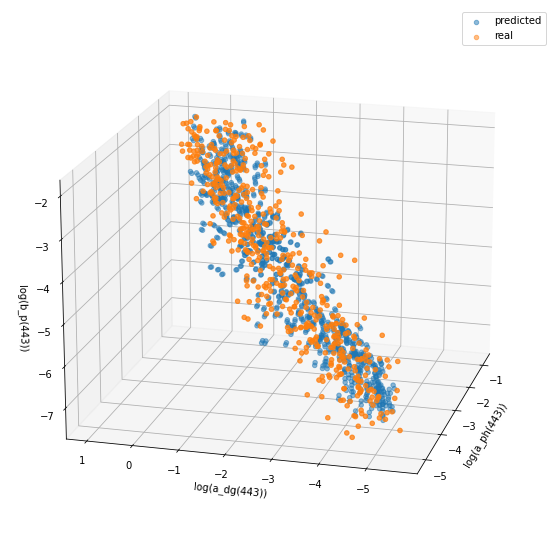

In [45]:
out_aph = []
Out_aph = []
out_b = []
Out_b = []
out_adg = []
Out_adg = []

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)

    out_aph.append(output[0])
    Out_aph.append(o[0])
    out_adg.append(output[1])
    Out_adg.append(o[1])
    out_b.append(output[2])
    Out_b.append(o[2])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(out_aph, out_adg, out_b, label='predicted', alpha=0.5)
ax1.scatter(Out_aph, Out_adg, Out_b, label='real', alpha=0.5)

ax1.set_xlabel('log(a_ph(443))')
ax1.set_ylabel('log(a_dg(443))')
ax1.set_zlabel('log(b_p(443))')
ax1.view_init(18,195)
plt.legend()
plt.show()


FInally, we can also draw a graphical representation of the network

No handles with labels found to put in legend.


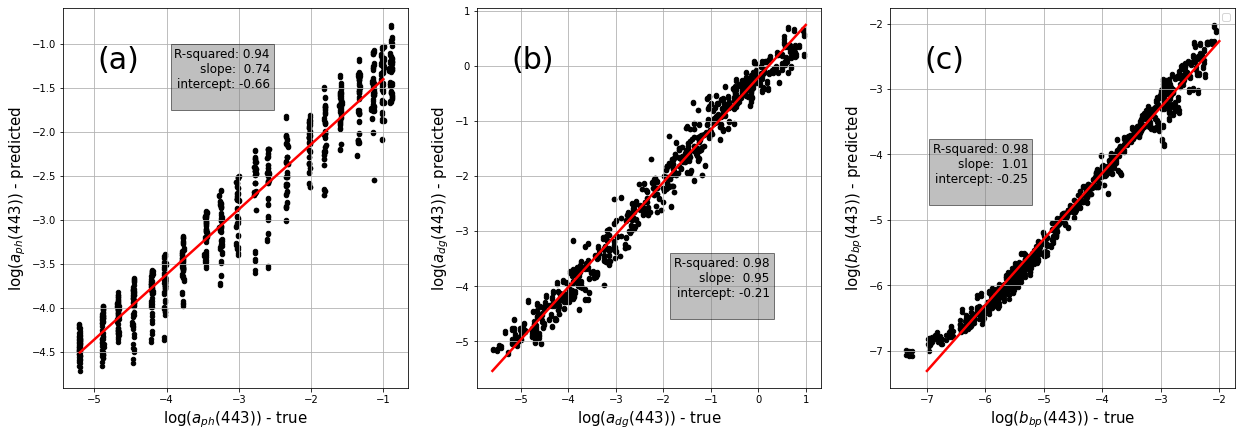

In [46]:
out_aph = []
Out_aph = []
out_b = []
Out_b = []
out_adg = []
Out_adg = []

for i, o in zip(inputs, outputs):
    output = winner_net.activate(i)

    out_aph.append(output[0])
    Out_aph.append(o[0])
    out_adg.append(output[1])
    Out_adg.append(o[1])
    out_b.append(output[2])
    Out_b.append(o[2])

fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharey=False)
axs[0].scatter(Out_aph, out_aph, s=20, c='black')
axs[1].scatter(Out_adg, out_adg, s=20, c='black')
axs[2].scatter(Out_b, out_b, s=20, c='black')
axs[0].set_xlabel(r'$\log(a_{ph}(443))$ - true', fontsize=15)
axs[0].set_ylabel(r'$\log(a_{ph}(443))$ - predicted', fontsize=15)
axs[1].set_xlabel(r'$\log(a_{dg}(443))$ - true', fontsize=15)
axs[1].set_ylabel(r'$\log(a_{dg}(443))$ - predicted', fontsize=15)
axs[2].set_xlabel(r'$\log(b_{bp}(443))$ - true', fontsize=15)
axs[2].set_ylabel(r'$\log(b_{bp}(443))$ - predicted', fontsize=15)

fit0 = LinearRegression().fit(np.asarray(Out_aph).reshape(-1, 1), np.asarray(out_aph).reshape(-1, 1))
y = fit0.predict(np.linspace(-5.2,-1,100).reshape(-1, 1))
axs[0].plot(np.linspace(-5.2,-1,100), y, c='r', lw=2.5)
Rsq = fit0.score(np.asarray(Out_aph).reshape(-1, 1), np.asarray(out_aph).reshape(-1, 1))
slope = fit0.coef_[0][0]
intercept = fit0.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[0].text(0.6, 0.75, stats, fontsize=12, bbox=bbox,
        transform=axs[0].transAxes, horizontalalignment='right')

fit1 = LinearRegression().fit(np.asarray(Out_adg).reshape(-1, 1), np.asarray(out_adg).reshape(-1, 1))
y = fit1.predict(np.linspace(-5.6,1,100).reshape(-1, 1))
axs[1].plot(np.linspace(-5.6,1,100), y, c='r', lw=2.5)
Rsq = fit1.score(np.asarray(Out_adg).reshape(-1, 1), np.asarray(out_adg).reshape(-1, 1))
slope = fit1.coef_[0][0]
intercept = fit1.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.85, 0.2, stats, fontsize=12, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

fit2 = LinearRegression().fit(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
y = fit2.predict(np.linspace(-7,-2,100).reshape(-1, 1))
axs[2].plot(np.linspace(-7,-2,100), y, c='r', lw=2.5)
Rsq = fit2.score(np.asarray(Out_b).reshape(-1, 1), np.asarray(out_b).reshape(-1, 1))
slope = fit2.coef_[0][0]
intercept = fit2.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[2].text(0.4, 0.5, stats, fontsize=12, bbox=bbox,
        transform=axs[2].transAxes, horizontalalignment='right')

for i in range(3):
    axs[i].grid(True)

for ax,label in zip(axs, ['(a)','(b)','(c)']):
        ax.text(0.1, 0.9, label, fontsize=30, transform=ax.transAxes, va='top')

plt.legend()
plt.show()

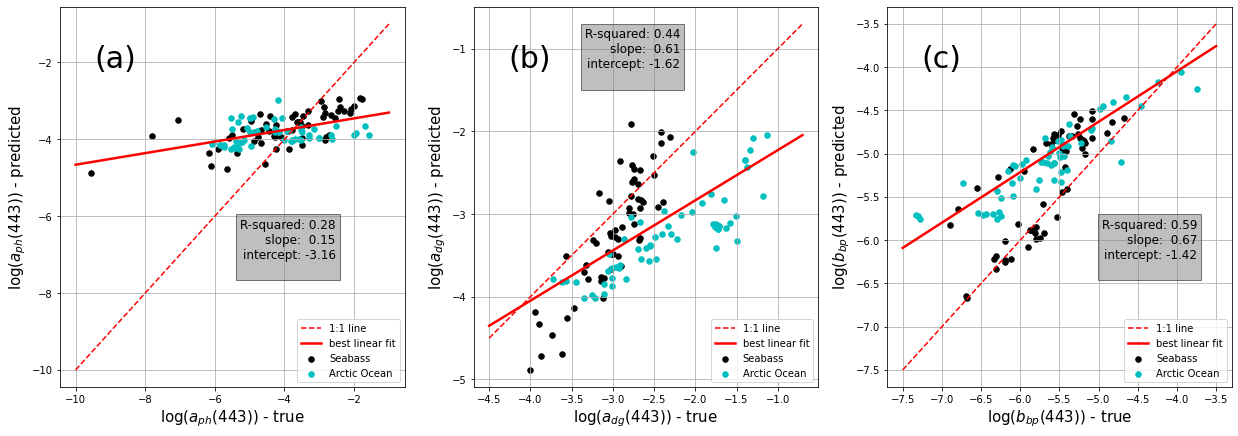

In [62]:
o0pred_s = []
o0pred_ao = []
o0real_s = []
o0real_ao = []
o1pred_s = []
o1pred_ao = []
o1real_s = []
o1real_ao = []
o2pred_s = []
o2pred_ao = []
o2real_s = []
o2real_ao = []

for i, o in zip(Inputs_s, Outputs_s):
    output = winner_net.activate(i)

    o0pred_s.append(output[0])
    o0real_s.append(o[0])
    o1pred_s.append(output[1])
    o1real_s.append(o[1])
    o2pred_s.append(output[2])
    o2real_s.append(o[2])

for i, o in zip(Inputs_ao, Outputs_ao):
    output = winner_net.activate(i)

    o0pred_ao.append(output[0])
    o0real_ao.append(o[0])
    o1pred_ao.append(output[1])
    o1real_ao.append(o[1])
    o2pred_ao.append(output[2])
    o2real_ao.append(o[2])


fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharey=False)
axs[0].scatter(o0real_s, o0pred_s, s=30, c='black', label='Seabass')
axs[0].scatter(o0real_ao, o0pred_ao, s=30, c='c', label='Arctic Ocean')
axs[1].scatter(o1real_s, o1pred_s, s=30, c='black', label='Seabass')
axs[1].scatter(o1real_ao, o1pred_ao, s=30, c='c', label='Arctic Ocean')
axs[2].scatter(o2real_s, o2pred_s, s=30, c='black', label='Seabass')
axs[2].scatter(o2real_ao, o2pred_ao, s=30, c='c', label='Arctic Ocean')
axs[0].set_xlabel(r'$\log(a_{ph}(443))$ - true', fontsize=15)
axs[0].set_ylabel(r'$\log(a_{ph}(443))$ - predicted', fontsize=15)
axs[1].set_xlabel(r'$\log(a_{dg}(443))$ - true', fontsize=15)
axs[1].set_ylabel(r'$\log(a_{dg}(443))$ - predicted', fontsize=15)
axs[2].set_xlabel(r'$\log(b_{bp}(443))$ - true', fontsize=15)
axs[2].set_ylabel(r'$\log(b_{bp}(443))$ - predicted', fontsize=15)

axs[0].plot(np.linspace(-10,-1,100), np.linspace(-10,-1,100), '--', c='r', lw=1.5, label='1:1 line')
axs[1].plot(np.linspace(-4.5,-0.7,100), np.linspace(-4.5,-0.7,100), '--', c='r', lw=1.5, label='1:1 line')
axs[2].plot(np.linspace(-7.5,-3.5,100), np.linspace(-7.5,-3.5,100), '--', c='r', lw=1.5, label='1:1 line')

fit0 = LinearRegression().fit(np.asarray(o0real_s+o0real_ao).reshape(-1, 1), np.asarray(o0pred_s+o0pred_ao).reshape(-1, 1))
y = fit0.predict(np.linspace(-10,-1,100).reshape(-1, 1))
axs[0].plot(np.linspace(-10,-1,100), y, c='r', lw=2.5, label='best linear fit')
Rsq = fit0.score(np.asarray(o0real_s+o0real_ao).reshape(-1, 1), np.asarray(o0pred_s+o0pred_ao).reshape(-1, 1))
slope = fit0.coef_[0][0]
intercept = fit0.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[0].text(0.8, 0.3, stats, fontsize=12, bbox=bbox,
        transform=axs[0].transAxes, horizontalalignment='right')

fit1 = LinearRegression().fit(np.asarray(o1real_s+o1real_ao).reshape(-1, 1), np.asarray(o1pred_s+o1pred_ao).reshape(-1, 1))
y = fit1.predict(np.linspace(-4.5,-0.7,100).reshape(-1, 1))
axs[1].plot(np.linspace(-4.5,-0.7,100), y, c='r', lw=2.5, label='best linear fit')
Rsq = fit1.score(np.asarray(o1real_s+o1real_ao).reshape(-1, 1), np.asarray(o1pred_s+o1pred_ao).reshape(-1, 1))
slope = fit1.coef_[0][0]
intercept = fit1.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[1].text(0.6, 0.8, stats, fontsize=12, bbox=bbox,
        transform=axs[1].transAxes, horizontalalignment='right')

fit2 = LinearRegression().fit(np.asarray(o2real_s+o2real_ao).reshape(-1, 1), np.asarray(o2pred_s+o2pred_ao).reshape(-1, 1))
y = fit2.predict(np.linspace(-7,-3.5,100).reshape(-1, 1))
axs[2].plot(np.linspace(-7.5,-3.5,100), y, c='r', lw=2.5, label='best linear fit')
Rsq = fit2.score(np.asarray(o2real_s+o2real_ao).reshape(-1, 1), np.asarray(o2pred_s+o2pred_ao).reshape(-1, 1))
slope = fit2.coef_[0][0]
intercept = fit2.intercept_
stats = (f'R-squared: {round(Rsq,2)}\n'
         f'slope:  {round(slope,2)}\n'
         f'intercept: {round(intercept[0],2)}\n')
bbox = dict(fc='gray', ec='black', alpha=0.5)
axs[2].text(0.9, 0.3, stats, fontsize=12, bbox=bbox,
        transform=axs[2].transAxes, horizontalalignment='right')

for i in range(3):
    axs[i].grid(True)
    axs[i].legend(loc='lower right')
for ax,label in zip(axs, ['(a)','(b)','(c)']):
        ax.text(0.1, 0.9, label, fontsize=30, transform=ax.transAxes, va='top')
    
plt.show()
